# Road surface detection and differentiation considering surface damages

## 1. Initial settings

---



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

Tue Jul 27 23:16:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install fastai==2.3.0
!pip3 install gputil

     |████████████████████████████████| 193 kB 7.6 MB/s 
     |████████████████████████████████| 53 kB 2.7 MB/s 
     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 22 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.7.1 which is incompati

In [3]:
from fastai.vision.all import *
import GPUtil as GPU


from pathlib import Path
import cv2
from PIL import Image
import warnings
from google.colab import drive
import os
from matplotlib.colors import ListedColormap
import time

In [4]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mkdir /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/
# !mkdir /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/images
# !mkdir /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/pt_labels
# !cp -a /content/drive/Shareddrives/Carro\ Autonomo/Datasets\ Caminho/RTKNet/images/. /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/images
# !cp -a /content/drive/Shareddrives/Carro\ Autonomo/Datasets\ Caminho/RTKNet/pt_labels/. /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/rtk/pt_labels

In [15]:
# from os import listdir
# from os.path import isfile, join
# files = [f for f in listdir('/content/drive/Shareddrives/Carro Autonomo/Datasets Caminho/RTKNet/labels_clean/') if isfile(join('/content/drive/Shareddrives/Carro Autonomo/Datasets Caminho/RTKNet/labels_clean/', f))]
# for f in files:
#   number = int(f[:-4])
#   # print(number)
#   if number >= 732:
#     # print(f)
#     !cp /content/drive/Shareddrives/Carro\ Autonomo/Datasets\ Caminho/RTKNet/'labels_clean/'$f /content/drive/Shareddrives/Carro\ Autonomo/ESC-training/datasets/ufsc-1/'labels/'$f
#     # break

## 2. Preparing the data

---



In [6]:
path = Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets')
path.ls()

(#3) [Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/rtk'),Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1'),Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/codes.txt')]

In [7]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['background', 'roadAsphalt', 'roadPaved', 'roadUnpaved',
       'roadMarking', 'speedBump', 'catsEye', 'stormDrain',
       'manholeCover', 'patchs', 'waterPuddle', 'pothole', 'cracks'],
      dtype='<U12')

In [37]:
image_path = path/'ufsc-1/images'
label_path = path/'ufsc-1/labels'
model_path = path/'..'

In [129]:
image_file_name = get_image_files(image_path)
label_file_name = get_image_files(label_path)
image_file_name.sort()
label_file_name.sort()
print(label_file_name)

# check labels
for name in label_file_name:
  mask = cv2.imread(str(name), cv2.IMREAD_ANYCOLOR) #maybe we should change this anycolor
  # print(mask.shape)
  umask = np.unique(mask)
  # if '735' in str(name):
    # print(name)
    # print(umask)
  for e in umask:
    assert e >= 0 and e <=12

[Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/labels/000000732.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/labels/000000733.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/labels/000000734.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/labels/000000735.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/labels/000000736.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/labels/000000737.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/labels/000000738.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/labels/000000739.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/labels/000000740.png'), Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/lab

##Converter tamanho e mudar nomes - Não rodar caso as pastas já estejam organizadas




In [42]:
# #CONVERTER LABEL
# fator = 5
# len(resize_name)
# u = 0
# for i in resize_name:
#   #img = Image.open(i)
#   mask = cv2.imread(str(i), cv2.IMREAD_ANYCOLOR)
#   mask_resized = cv2.resize(mask, (mask.shape[1]//fator, 
#                           mask.shape[0]//fator),
#                           interpolation=cv2.INTER_NEAREST)
#   mask_resized = (np.array(mask_resized)).astype('uint8')
#   print(u,i.name,mask_resized.shape, np.unique(mask_resized))
#   cv2.imwrite('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/labels/outputs_resized/%s.png' %u,mask_resized, [cv2.IMWRITE_JPEG_QUALITY, 100])
#   u = u + 1

In [43]:
# #CONVERTER IMAGE
# fator = 5
# len(resize_name1)
# u = 0
# for i in resize_name1:
#   #img = Image.open(i)
#   mask = cv2.imread(str(i), cv2.IMREAD_ANYCOLOR)
#   mask_resized = cv2.resize(mask, (mask.shape[1]//fator, 
#                           mask.shape[0]//fator),
#                           interpolation=cv2.INTER_NEAREST)
#   mask_resized = (np.array(mask_resized)).astype('uint8')
#   print(u,i.name,mask_resized.shape, np.unique(mask_resized))
#   cv2.imwrite('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_resized/%s.png' %u,mask_resized, [cv2.IMWRITE_JPEG_QUALITY, 100])
#   u = u + 1

In [44]:
# #CONVERTER RESULT_COLOR
# fator = 5
# len(resize_name2)
# u = 0
# for i in resize_name2:
#   #img = Image.open(i)
#   mask = cv2.imread(str(i), cv2.IMREAD_ANYCOLOR)
#   mask_resized = cv2.resize(mask, (mask.shape[1]//fator, 
#                           mask.shape[0]//fator),
#                           interpolation=cv2.INTER_NEAREST)
#   mask_resized = (np.array(mask_resized)).astype('uint8')
#   print(u,i.name,mask_resized.shape, np.unique(mask_resized))
#   cv2.imwrite('/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/results_color/outputs_resized/%s.png' %u,mask_resized, [cv2.IMWRITE_JPEG_QUALITY, 100])
#   u = u + 1

In [45]:
# import os
# u

In [46]:
# #renomeando LABELS os itens da pasta para continuarem no padrão
# for i in range(0, u):
#     x = str(732+i)
#     os.rename(r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/labels/outputs_resized/'+ str(i) +'.png', 
#               r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/labels/outputs_resized/000000'+ x +'.png')

In [47]:
# #renomeando IMAGES os itens da pasta para continuarem no padrão
# for i in range(0, u):
#     x = str(732+i)
#     os.rename(r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_resized/'+ str(i) +'.png', 
#               r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_resized/000000'+ x +'.png')

In [48]:
# #renomeando RESULTS_COLOR os itens da pasta para continuarem no padrão
# for i in range(0, u):
#     x = str(732+i)
#     os.rename(r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/results_color/outputs_resized/'+ str(i) +'.png', 
#               r'/content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/results_color/outputs_resized/000000'+ x +'.png')

## Continuação dos dados

In [10]:
#create valid.txt
(image_path/'..').ls()
with open(image_path/'../valid.txt', 'w') as file:
  i = 0
  for name in image_file_name:
    i+=1
    if i%5==0: # 20% valid
      print(name.name, file=file)

In [11]:
rgb_to_hex = '#%02x%02x%02x'
cmap = [
  "#{0:02x}{1:02x}{2:02x}".format(0,0,0), #background
  "#{0:02x}{1:02x}{2:02x}".format(85,170,127), #roadPaved
  "#{0:02x}{1:02x}{2:02x}".format(255,170,127), ##roadUnpaved
  "#{0:02x}{1:02x}{2:02x}".format(255,255,255), #roadMarking
  "#{0:02x}{1:02x}{2:02x}".format( 255,85,255), #speedBump
  "#{0:02x}{1:02x}{2:02x}".format( 255,255,127), #catsEye
  "#{0:02x}{1:02x}{2:02x}".format(170,0,127), #stormDrain
  "#{0:02x}{1:02x}{2:02x}".format( 0,255,255), #manholeCover
  "#{0:02x}{1:02x}{2:02x}".format(0,0, 27), #patchs
  "#{0:02x}{1:02x}{2:02x}".format(170,0,0), #waterPuddle
  "#{0:02x}{1:02x}{2:02x}".format(255,0,0), #pothole
  "#{0:02x}{1:02x}{2:02x}".format( 255,85,0), #cracks
]
cmap

['#000000',
 '#55aa7f',
 '#ffaa7f',
 '#ffffff',
 '#ff55ff',
 '#ffff7f',
 '#aa007f',
 '#00ffff',
 '#00001b',
 '#aa0000',
 '#ff0000',
 '#ff5500']

In [12]:
img_f = image_file_name[100]
get_y_fn = lambda x: label_path/f'{x.stem}{x.suffix}'
print(img_f)
get_y_fn(img_f)

/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/images/000000832.png


Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets/ufsc-1/labels/000000832.png')

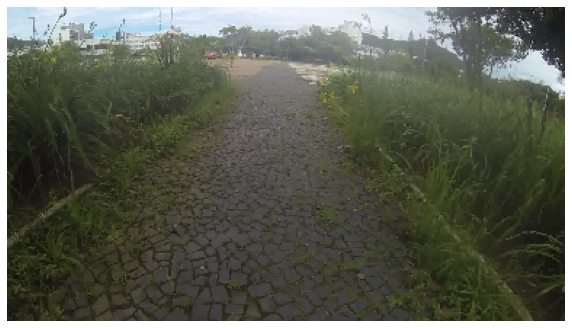

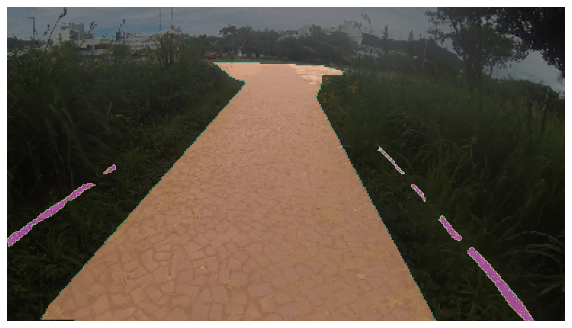

In [123]:
img_f = image_file_name[2]
img = PILImage.create(img_f)
mask = PILMask.create(get_y_fn(img_f))
img.show(figsize=(10,10))
ax = img.show(figsize=(10,10))
mask.show(ctx=ax, figsize=(10,10), cmap=ListedColormap(cmap), vmax=len(cmap))

In [16]:
src_size = np.array(mask.shape)
src_size

array([216, 384])

## 3. First Step - Without weights

---



### 3.1. First step Datasets

---



In [69]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU RAM Free: 4667MB | Used: 10442MB | Util  69% | Total 15109MB


In [18]:
size = PILMask.create(get_y_fn(img_f)).shape
print(size)
batch_size = 8

(216, 384)


In [19]:
data_block = DataBlock(blocks=(ImageBlock, MaskBlock(codes = codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=11),
    get_y=get_y_fn,
    )

In [20]:
# data_block.summary(image_path,show_batch=True)

In [21]:
datasets = data_block.datasets(image_path)

In [22]:
print(datasets.train[0])
print(datasets.valid[0])
print(len(datasets.train))
print(len(datasets.valid))

(PILImage mode=RGB size=384x216, PILMask mode=L size=384x216)
(PILImage mode=RGB size=384x216, PILMask mode=L size=384x216)
156
38


In [23]:
dataloaders = data_block.dataloaders(image_path, bs=batch_size, num_workers=4)

In [24]:
dataloaders.splits

(#2) [[4, 29, 167, 93, 58, 70, 183, 97, 44, 166, 35, 124, 36, 134, 163, 65, 165, 131, 22, 127, 82, 1, 13, 54, 177, 115, 39, 159, 10, 19, 147, 17, 9, 123, 86, 156, 52, 12, 102, 3, 162, 76, 91, 48, 26, 96, 112, 49, 87, 33, 16, 30, 178, 153, 171, 72, 130, 145, 24, 128, 51, 56, 63, 81, 0, 62, 133, 148, 154, 68, 41, 139, 105, 14, 79, 42, 122, 189, 151, 142, 161, 120, 137, 27, 34, 188, 78, 8, 64, 192, 69, 164, 73, 114, 168, 60, 6, 110, 89, 88, 101, 180, 117, 100, 173, 170, 191, 75, 149, 118, 99, 31, 43, 92, 59, 71, 15, 66, 25, 125, 40, 113, 181, 193, 109, 53, 160, 46, 21, 84, 121, 186, 90, 95, 74, 155, 182, 18, 23, 2, 85, 61, 103, 80, 108, 126, 11, 107, 119, 67, 184, 28, 129, 140, 111, 190],[187, 47, 146, 158, 7, 50, 55, 152, 141, 106, 20, 179, 157, 57, 98, 185, 144, 143, 94, 150, 116, 136, 5, 45, 176, 172, 135, 32, 38, 175, 169, 138, 104, 174, 37, 132, 77, 83]]

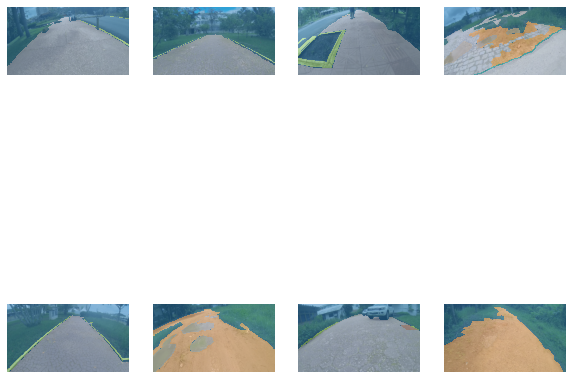

In [25]:
# start = time.time()
dataloaders.show_batch(figsize=(10,10))
# end = time.time()
# print(end-start)

### 3.2. First step Model

---



In [26]:
from fastai.vision.models import resnet18
used_model = resnet18

In [27]:
name2id = {v:k for k,v in enumerate(codes)}
name2id

{'background': 0,
 'catsEye': 6,
 'cracks': 12,
 'manholeCover': 8,
 'patchs': 9,
 'pothole': 11,
 'roadAsphalt': 1,
 'roadMarking': 4,
 'roadPaved': 2,
 'roadUnpaved': 3,
 'speedBump': 5,
 'stormDrain': 7,
 'waterPuddle': 10}

In [28]:
# check what is supp
# void_code = name2id['manholeCover']
# def acc_rtk(input, target):
#     target = target.squeeze(1)
#     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()


def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [36]:
metrics=acc_rtk
wd=1e-2

Path('/content/drive/Shareddrives/Carro Autonomo/ESC-training/datasets')

In [130]:
learn = unet_learner(dataloaders, used_model, metrics=metrics, wd=wd, pretrained=False,
                     loss_func=CrossEntropyLossFlat(axis=1), path=model_path, model_dir='fastai-training',y_range=(0,1))

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0020892962347716093)

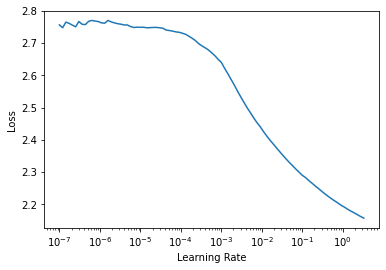

In [131]:
learn.lr_find()

In [132]:
lr = 5e-1
print(slice(lr))

slice(None, 0.5, None)


In [133]:
cbs = [SaveModelCallback(every_epoch=True, monitor='acc_rtk', fname='model_test')]

In [139]:
# fit_one_cycle aceita wd. wd ja nao foi escolhido no learn? SIM, usa o wd do learn se wd=None
learn.fit_one_cycle(10, lr_max=lr, pct_start=0.9, cbs=cbs)

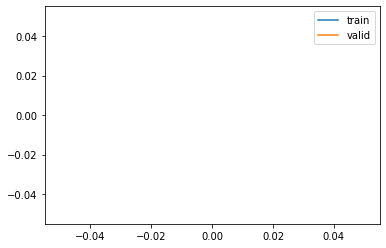

In [142]:
# por algum motivo tem q rodar isso antes de rodar o show_results, caso contrário o gráfico nao funciona
learn.recorder.plot_loss()

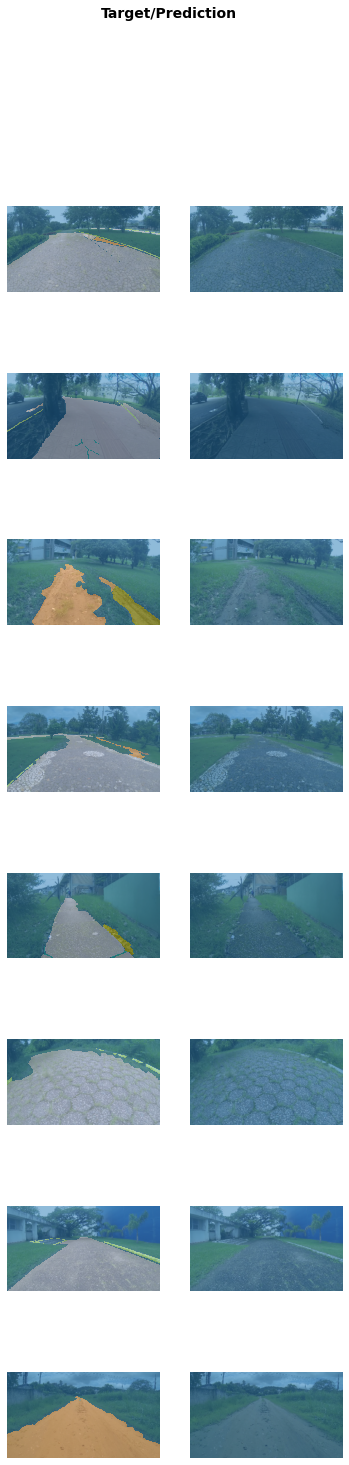

In [141]:
learn.show_results(ds_idx=0)

In [ ]:
# RODAR CASO TENHA TRAVADO - na vdd unfreeze vai descongelar todas os parametros, se a rede ja comeca com todos os parametros descongelados
# isso nao faz diferenca
learn.unfreeze()

In [116]:
learn.save('first-stage-first-step');

In [ ]:
learn.load('first-stage-first-step');

In [72]:
# learn.show_results()

### 3.3. Interpret

---



In [109]:
interp = SegmentationInterpretation.from_learner(learn)

In [110]:
top_losses, top_idxs = interp.top_losses()
len(top_losses)

38

(array([8., 7., 7., 5., 3., 3., 2., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1.]),
 array([  6.3052964,  12.506828 ,  18.70836  ,  24.909893 ,  31.111425 ,
         37.312958 ,  43.51449  ,  49.716022 ,  55.917553 ,  62.119083 ,
         68.32062  ,  74.52215  ,  80.72368  ,  86.92522  ,  93.12675  ,
         99.32828  , 105.52981  , 111.73134  , 117.93288  , 124.13441  ,
        130.33594  ], dtype=float32),
 <a list of 20 Patch objects>)

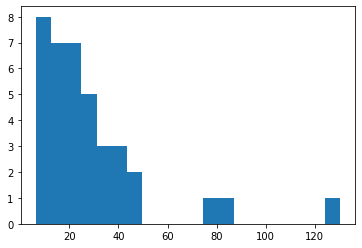

In [111]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

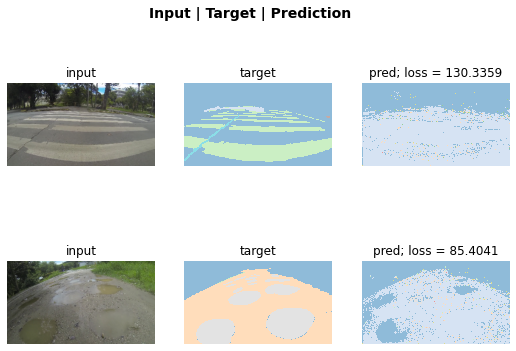

In [112]:
# top loss idxs of images
interp.plot_top_losses(2)

In [137]:
# check frozen layers
for name, module in learn.model.named_parameters():
  print(name)
  print(module.requires_grad)
    # module.requires_grad_(False)

layers.0.0.weight
True
layers.0.1.weight
True
layers.0.1.bias
True
layers.0.4.0.conv1.weight
True
layers.0.4.0.bn1.weight
True
layers.0.4.0.bn1.bias
True
layers.0.4.0.conv2.weight
True
layers.0.4.0.bn2.weight
True
layers.0.4.0.bn2.bias
True
layers.0.4.1.conv1.weight
True
layers.0.4.1.bn1.weight
True
layers.0.4.1.bn1.bias
True
layers.0.4.1.conv2.weight
True
layers.0.4.1.bn2.weight
True
layers.0.4.1.bn2.bias
True
layers.0.5.0.conv1.weight
True
layers.0.5.0.bn1.weight
True
layers.0.5.0.bn1.bias
True
layers.0.5.0.conv2.weight
True
layers.0.5.0.bn2.weight
True
layers.0.5.0.bn2.bias
True
layers.0.5.0.downsample.0.weight
True
layers.0.5.0.downsample.1.weight
True
layers.0.5.0.downsample.1.bias
True
layers.0.5.1.conv1.weight
True
layers.0.5.1.bn1.weight
True
layers.0.5.1.bn1.bias
True
layers.0.5.1.conv2.weight
True
layers.0.5.1.bn2.weight
True
layers.0.5.1.bn2.bias
True
layers.0.6.0.conv1.weight
True
layers.0.6.0.bn1.weight
True
layers.0.6.0.bn1.bias
True
layers.0.6.0.conv2.weight
True
layers.

### 3.4. Confusion Matrix - not working

---



In [88]:
mean_cm, single_img_cm = interp._generate_confusion()

AttributeError: ignored

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (18, 13, 13))

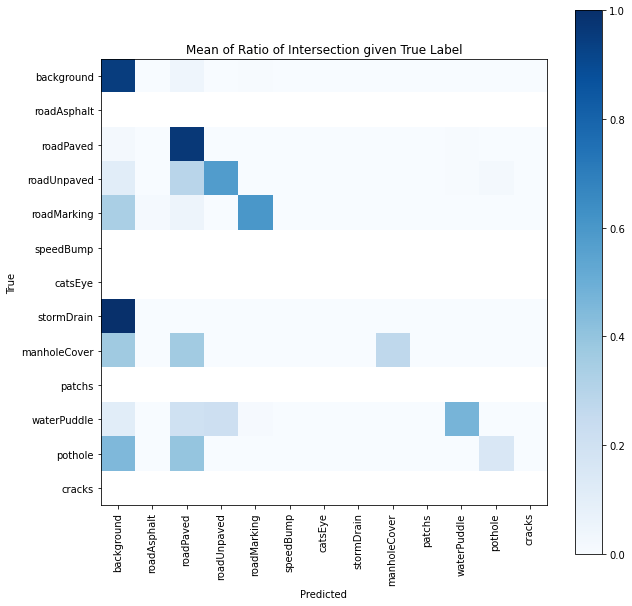

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

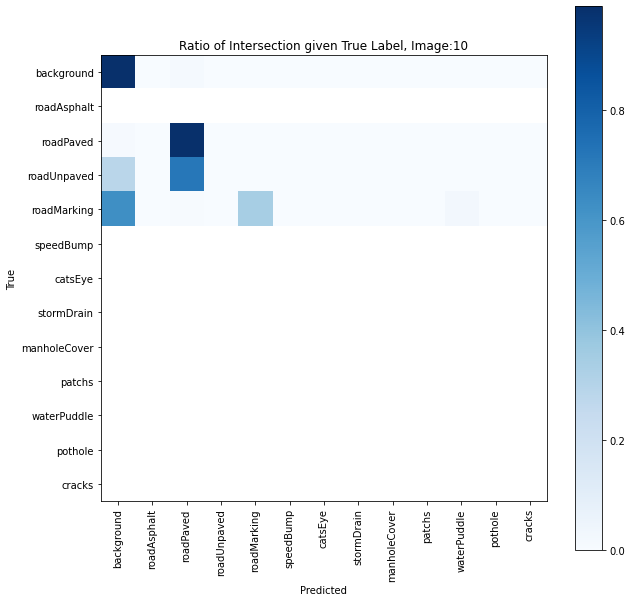

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

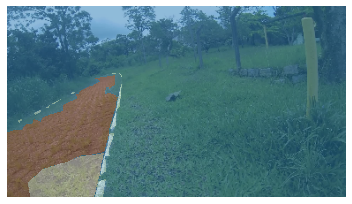

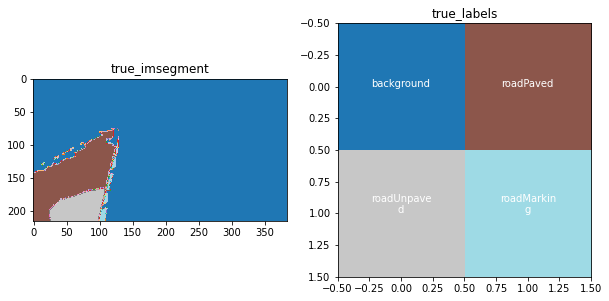

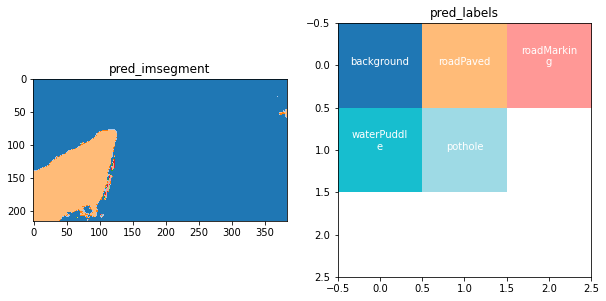

In [ ]:
# show xyz
interp.show_xyz(i)

### 3.5. First model continuation

---



In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(100, lr_max=lr, pct_start=0.9, cbs=cbs)

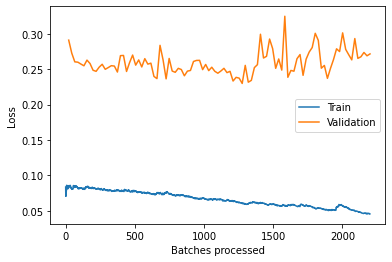

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('first-stage-second-step');

In [ ]:
learn.load('first-stage-second-step');

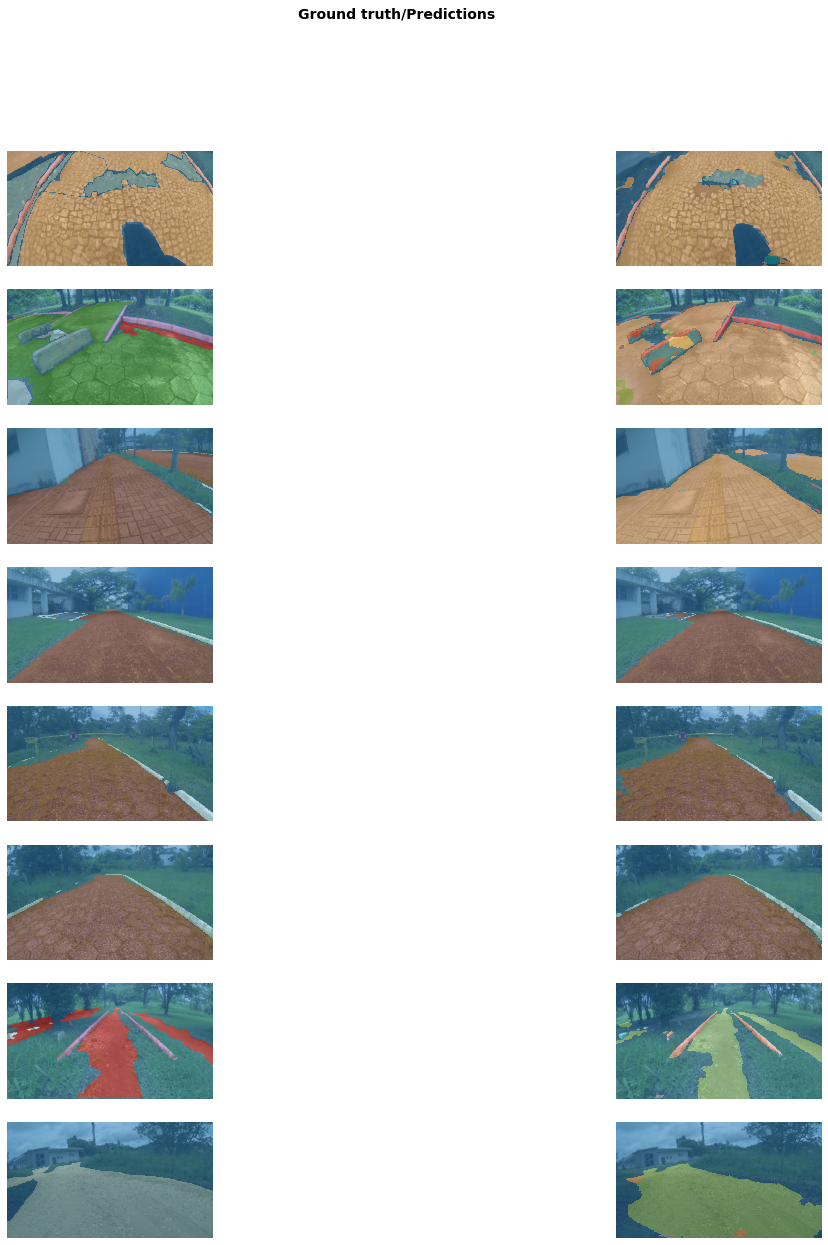

In [ ]:
# learn.show_results()

### 3.6. Confusion Matrix - not working

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (18, 13, 13))

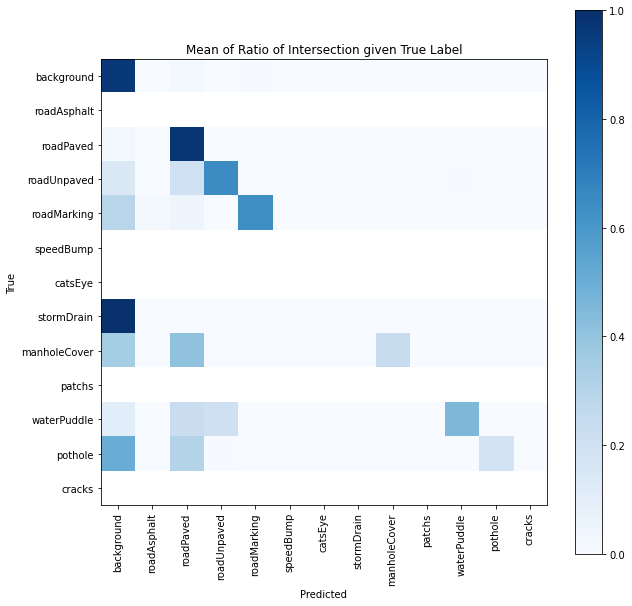

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

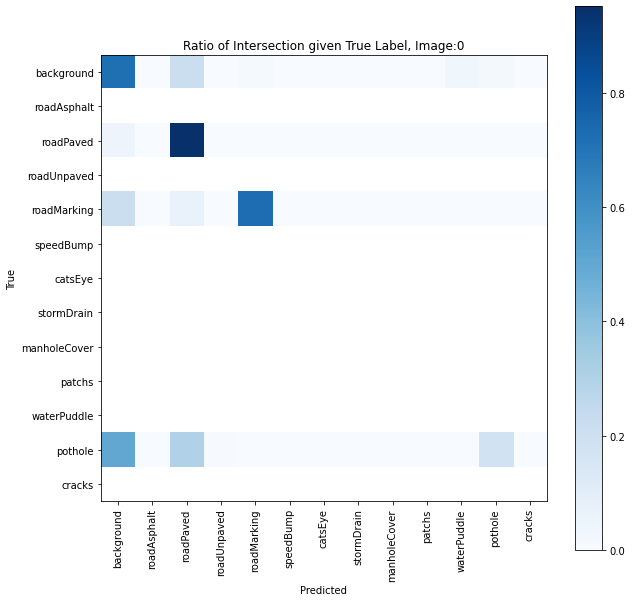

In [ ]:
# single image class performance
i = 0
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

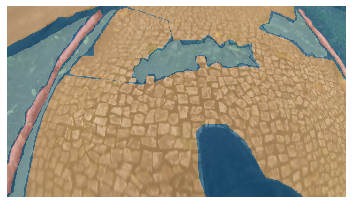

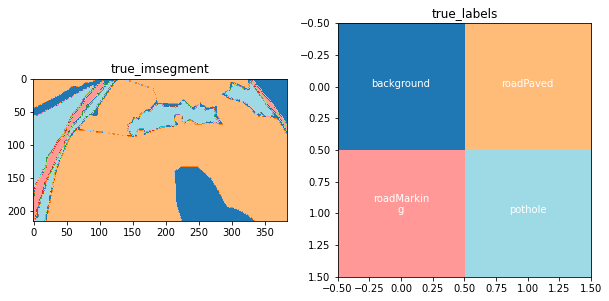

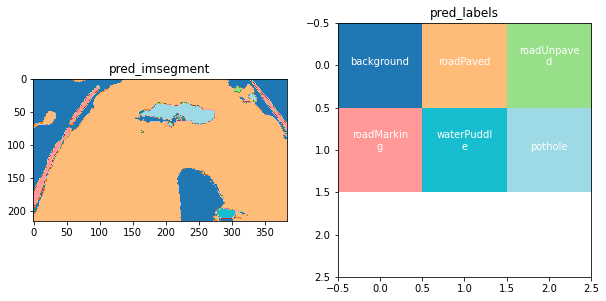

In [ ]:
# show xyz
interp.show_xyz(i)

### 3.7. Interpret

---



In [118]:
learn.interpret

ModuleAttributeError: ignored

### 3.8. Saving

---



In [ ]:
learn.save('stage-2_dsufsc1')

In [ ]:
learn.export('/content/gdrive/My Drive/Datasets Caminho/DATASET - UFSC/export_dsufsc1.pkl')

In [ ]:
data=None
learn=None
gc.collect()

53986

## 4. Second Step - With weights

---



### 4.1. Second step Datasets

---



In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11953MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_output_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

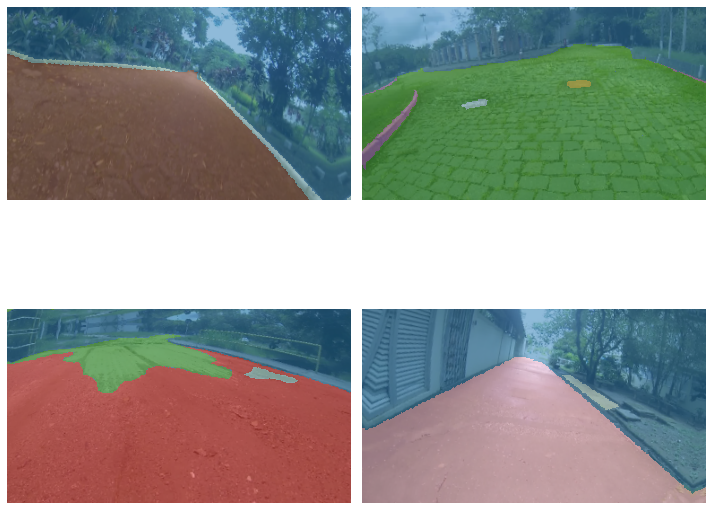

In [ ]:
data.show_batch(2, figsize=(10,10))

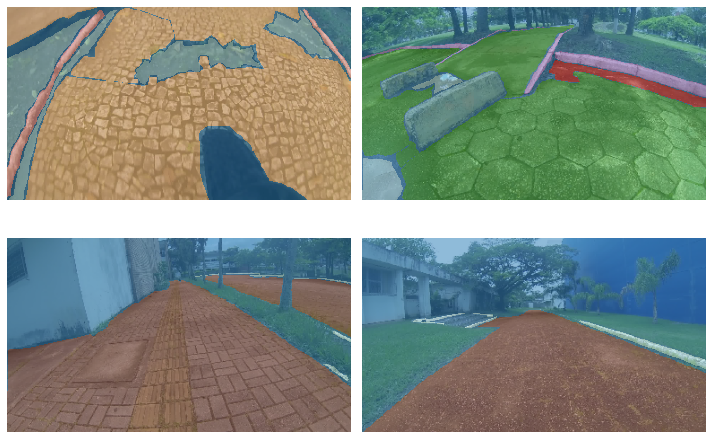

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

### 4.2. Second step Model

---



In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['manholeCover']

def acc_rtk(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_rtk
wd=1e-2

In [ ]:
balanced_loss = CrossEntropyFlat(axis=1, weight=torch.tensor([1.0,5.0,6.0,7.0,75.0,1000.0,3100.0,3300.0,0.0,270.0,2200.0,1000.0,180.0]).cuda())

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, loss_func=balanced_loss, wd=wd)

In [ ]:
learn.load('stage-2_dsufsc1')

Learner(data=ImageDataBunch;

Train: LabelList (176 items)
x: SegmentationItemList
Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384)
y: SegmentationLabelList
ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384)
Path: /content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean;

Valid: LabelList (18 items)
x: SegmentationItemList
Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384)
y: SegmentationLabelList
ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384)
Path: /content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2),

In [ ]:
!/opt/bin/nvidia-smi

Wed May 12 14:10:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   3316MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


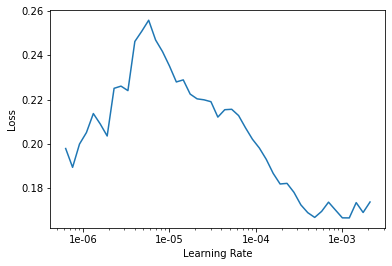

In [ ]:
#CUDA_LAUNCH_BLOCKING=1
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(100, slice(lr), pct_start=0.9, 
                    callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='saved_net2')])

In [ ]:
# RODAR CASO TENHA TRAVADO
learn.unfreeze()

In [ ]:
# RODAR TREINAMENTO INTERROMPIDO
p = 8
#p é a época que o treinamento deve continuar
learn.fit_one_cycle(10, slice(lr), 
                    start_epoch=p,
                    callbacks=[SaveModelCallback(learn, 
                    every='epoch', monitor='accuracy', 
                    name='saved_net2')])

Loaded saved_net2_7


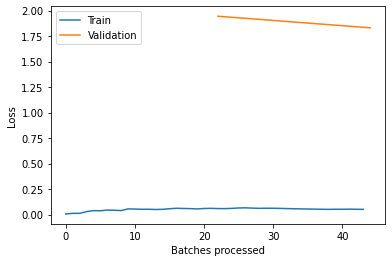

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-weights_dsufsc1')

In [ ]:
learn.load('stage-1-weights_dsufsc1');

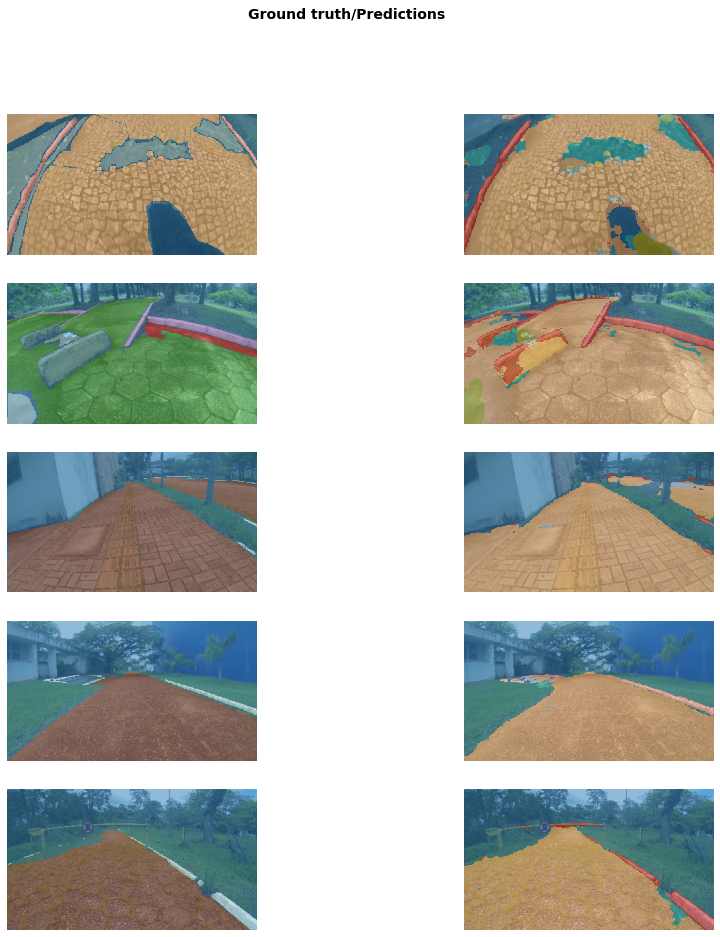

In [ ]:
learn.show_results(rows=5, figsize=(15,15))

### 4.3. Interpret

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
top_losses, top_idxs = interp.top_losses((216,384))

(array([13.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.816410e-01, 5.587856e+01, 1.114755e+02, 1.670724e+02, 2.226693e+02, 2.782663e+02, 3.338632e+02, 3.894601e+02,
        4.450570e+02, 5.006539e+02, 5.562509e+02, 6.118478e+02, 6.674447e+02, 7.230416e+02, 7.786385e+02, 8.342355e+02,
        8.898324e+02, 9.454293e+02, 1.001026e+03, 1.056623e+03, 1.112220e+03], dtype=float32),
 <a list of 20 Patch objects>)

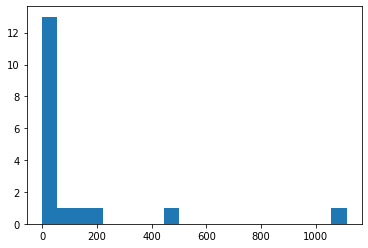

In [ ]:
# plot loss distribution
plt.hist(to_np(top_losses), bins=20)

In [ ]:
# top loss idxs of images
top_idxs[:5]

tensor([ 9,  0, 16,  1, 12])

### 4.4. Confusion Matrix

---



In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (18, 13, 13))

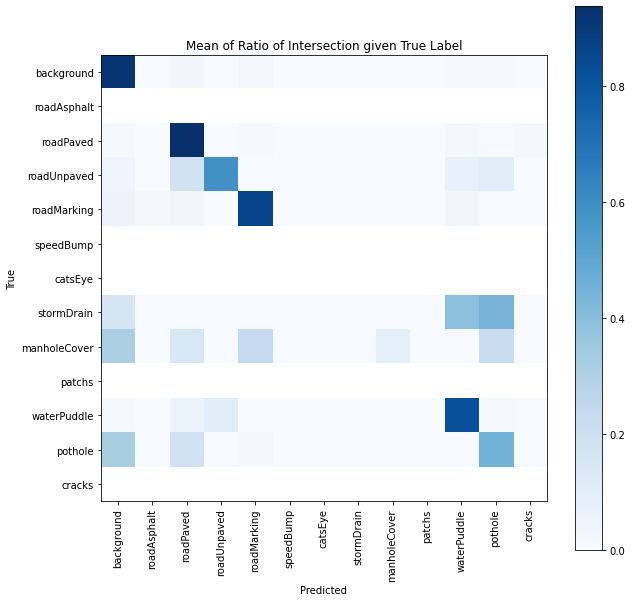

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

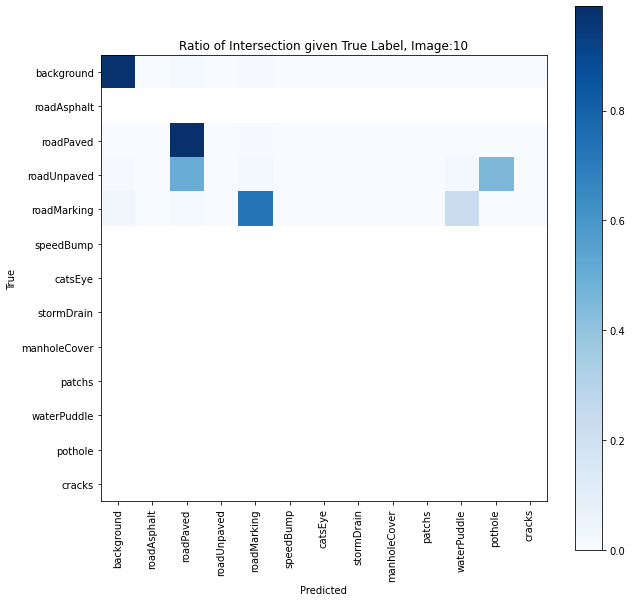

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

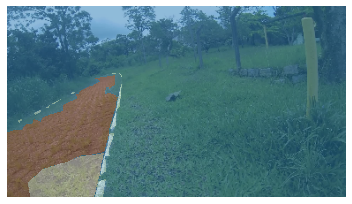

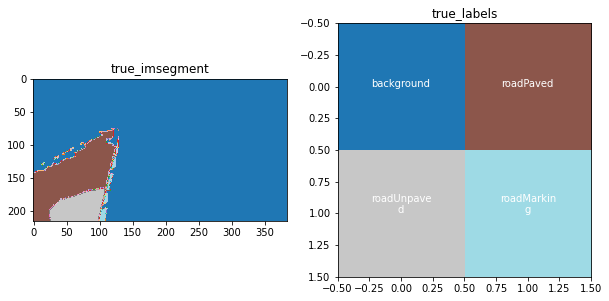

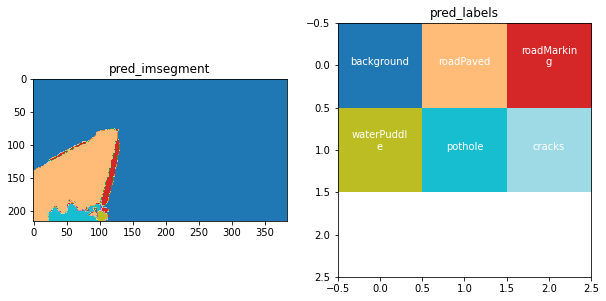

In [ ]:
# show xyz
interp.show_xyz(i)

### 4.5. Second model continuation

---



In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(100, lrs, pct_start=0.8, callbacks=[SaveModelCallback(learn, every='epoch',  
                  monitor='accuracy', name='saved_net2_continuation')])

In [ ]:
# RODAR CASO TENHA TRAVADO
learn.unfreeze()

In [ ]:
# RODAR TREINAMENTO INTERROMPIDO
p = 
#p é a época que o treinamento deve continuar
learn.fit_one_cycle(100, lrs, 
                    start_epoch=p,
                    callbacks=[SaveModelCallback(learn, 
                    every='epoch', monitor='accuracy', 
                    name='saved_net2_continuation')])

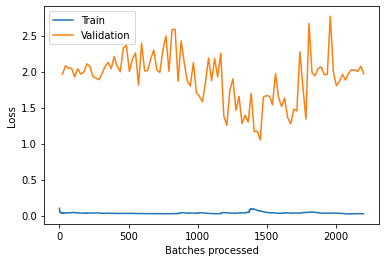

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-weights_dsufsc1')

In [ ]:
learn.load('stage-2-weights_dsufsc1');

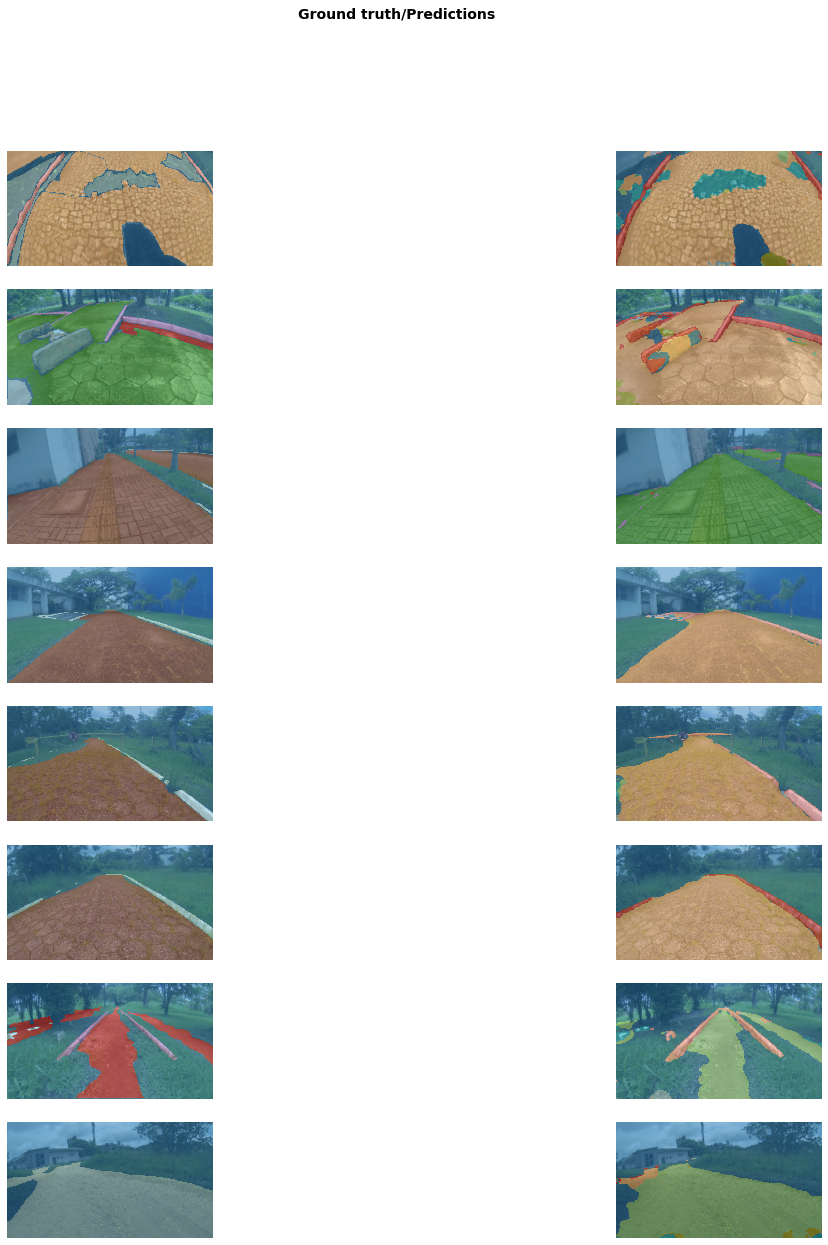

In [ ]:
learn.show_results(rows=25, figsize=(20,20))

### 4.6. Confusion Matrix

---



In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (18, 13, 13))

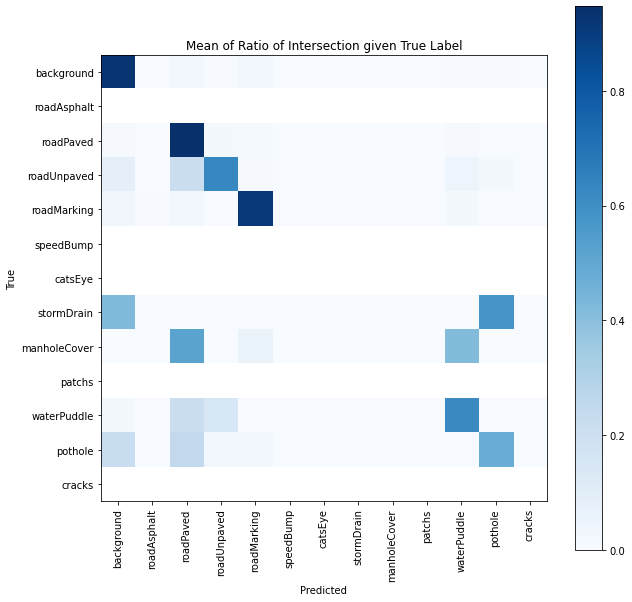

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

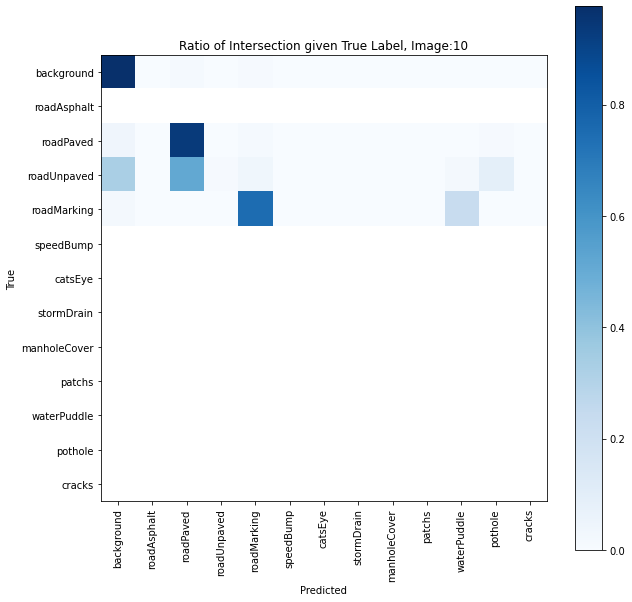

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

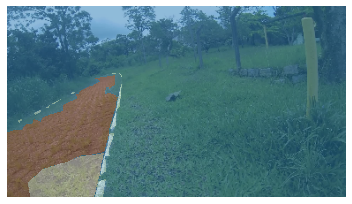

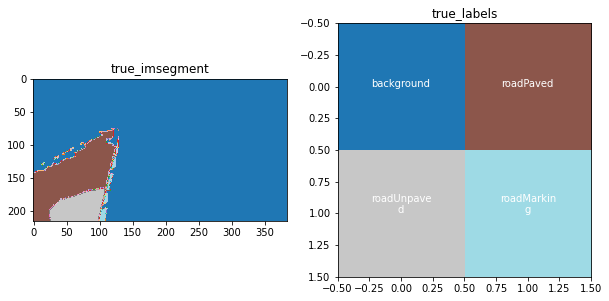

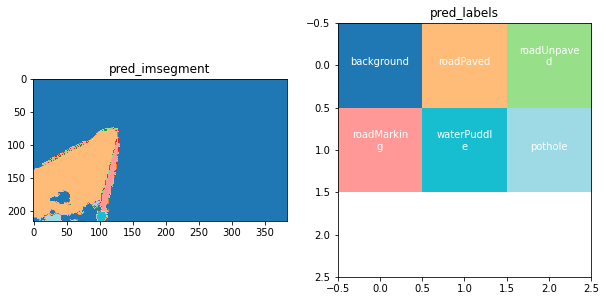

In [ ]:
# show xyz
interp.show_xyz(i)

### 4.7. Interpret

---



In [ ]:
learn.interpret

<bound method _learner_interpret of Learner(data=ImageDataBunch;

Train: LabelList (176 items)
x: SegmentationItemList
Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384)
y: SegmentationLabelList
ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384)
Path: /content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean;

Valid: LabelList (18 items)
x: SegmentationItemList
Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384),Image (3, 216, 384)
y: SegmentationLabelList
ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384),ImageSegment (1, 216, 384)
Path: /content/gdrive/Shareddrives/Carro Autonomo/Datasets Caminho/DATASET - UFSC/images/outputs_clean;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64

### 4.8. Saving

---



In [ ]:
learn.save('stage-2-weights_dsufsc1')
#mudar nomes de arquivos
learn.export('/content/gdrive/My Drive/Datasets Caminho/DATASET - UFSC/export_dsufsc_v10_100epochs.pkl')

## 5. Using a saved model to Predict

---



In [ ]:
size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11405MB of GPU RAM free


In [ ]:
src = (SegmentationItemList.from_folder(path_output_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34)

In [ ]:
learn.load('stage-2-weights_dsufsc1');

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
mean_cm, single_img_cm = interp._generate_confusion()

In [ ]:
mean_cm.shape, single_img_cm.shape

((13, 13), (18, 13, 13))

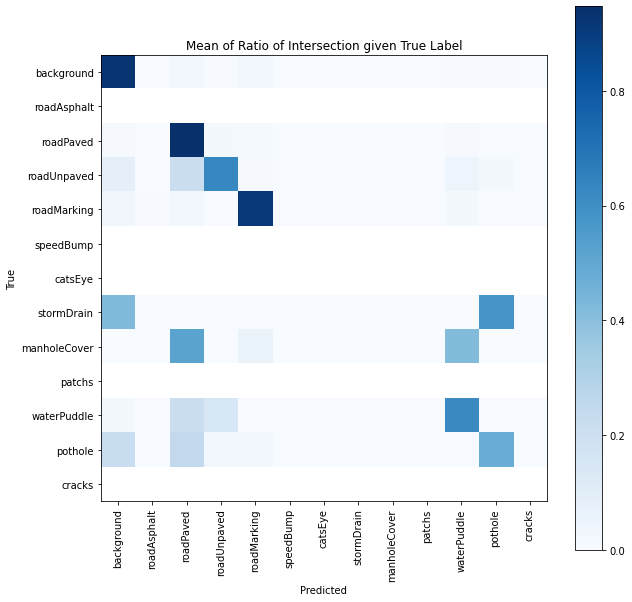

In [ ]:
# global class performance
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

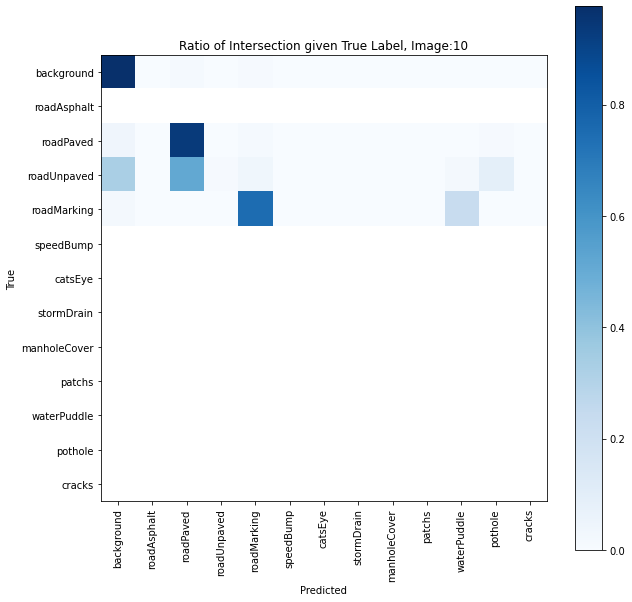

In [ ]:
# single image class performance
i = 10
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

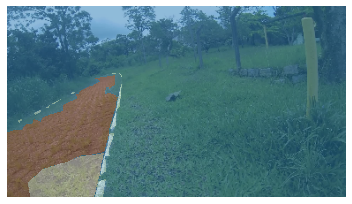

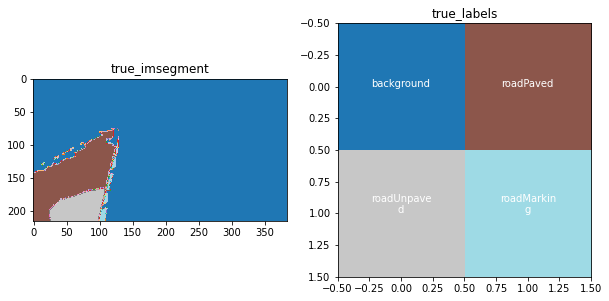

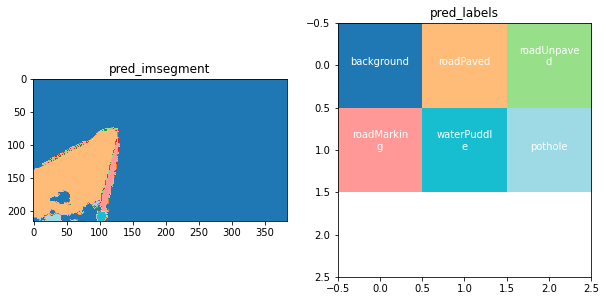

In [ ]:
# show xyz
interp.show_xyz(i)

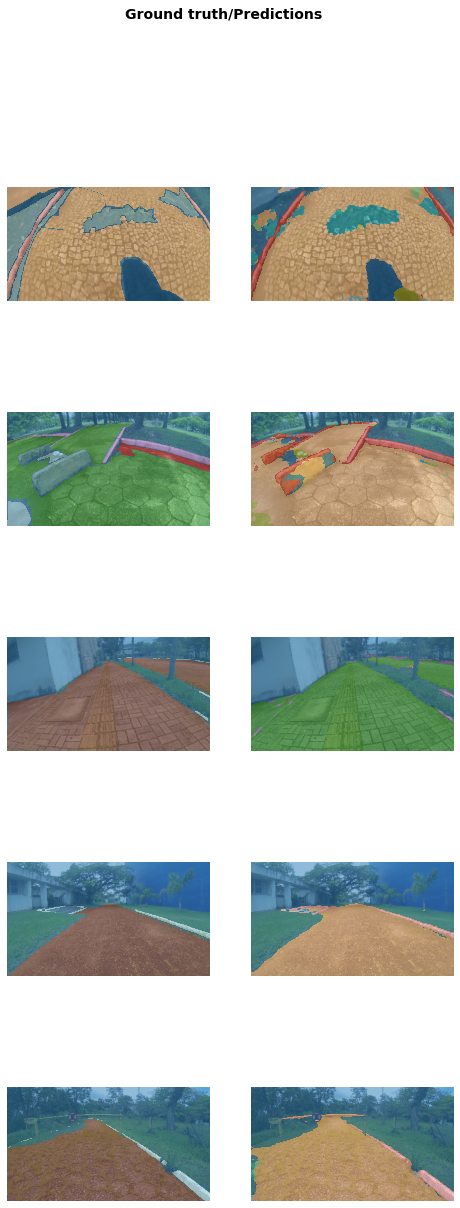

In [ ]:
learn.show_results()

## 6. Saving the Results

---



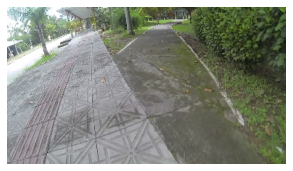

In [ ]:
img_f = fnames[10]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
import time
start = time.time()
prediction = learn.predict(img)
print(time.time() - start)

2.2406399250030518


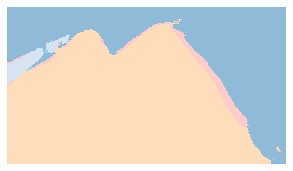

In [ ]:
prediction[0].show(figsize=(5,5))

In [ ]:
results_save = 'results'
path_rst = path/results_save
path_rst.mkdir(exist_ok=True)

In [ ]:
def save_preds(names):
    i=0
    #names = dl.dataset.items
    
    for b in names:
        img_s = fnames[i]
        img_toSave = open_image(img_s)
        img_split = f'{img_s}'
        #sempre checar o esse numero aqui em baixo para ver se está correto com o path!! 
        img_split = img_split[97:]
        predictionSave = learn.predict(img_toSave)
        predictionSave[0].save(path_rst/img_split) #Save Image
        i += 1
        print(i)

In [ ]:
save_preds(fnames)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


## 7. Coloring the Results

---




In [ ]:
import os
import glob
import base64
import cv2 as cv
cv.__version__

'4.1.2'

In [ ]:
colored_results = 'results_color'
path_crst = path/colored_results
path_crst.mkdir(exist_ok=True)

In [ ]:
%load_ext cython

In [ ]:
%%cython -a
import cython
cimport numpy
import cv2 as cv
import numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
#def colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
cpdef numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] colorfull_fast(numpy.ndarray[numpy.uint8_t, ndim=3, mode="c"] frame):
  # set the variable extension types
  cdef int x, y, width, height, b, g, r

  #frame = cv.imdecode(np.frombuffer(byteframe, np.uint8), -1)

  # grab the image dimensions
  width = 216
  height = 384
    
  # loop over the image, pixel by pixel
  for x in range(width):
    for y in range(height):
      b, g, r = frame[x, y]
      if (b, g, r) == (0,0,0): #background
        frame[x, y] = (0,0,0)
      elif (b, g, r) == (1,1,1): #roadAsphalt
        frame[x, y] = (85,85,255)
      elif (b, g, r) == (2,2,2): #roadPaved
        frame[x, y] = (85,170,127)
      elif (b, g, r) == (3,3,3): #roadUnpaved
        frame[x, y] = (255,170,127) 
      elif (b, g, r) == (4,4,4): #roadMarking
        frame[x, y] = (255,255,255) 
      elif (b, g, r) == (5,5,5): #speedBump
        frame[x, y] = (255,85,255)
      elif (b, g, r) == (6,6,6): #catsEye
        frame[x, y] = (255,255,127)          
      elif (b, g, r) == (7,7,7): #stormDrain
        frame[x, y] = (170,0,127) 
      elif (b, g, r) == (8,8,8): #manholeCover
        frame[x, y] = (0,255,255) 
      elif (b, g, r) == (9,9,9): #patchs
        frame[x, y] = (0,0,127) 
      elif (b, g, r) == (10,10,10): #waterPuddle
        frame[x, y] = (170,0,0)
      elif (b, g, r) == (11,11,11): #pothole
        frame[x, y] = (255,0,0)
      elif (b, g, r) == (12,12,12): #cracks
        frame[x, y] = (255,85,0)
 
  frame = cv.cvtColor(frame,cv.COLOR_BGR2RGB)
  
  # return the colored image
  return frame

In [ ]:
import timeit
# Count variables
fqtd = 0

filenames = [img for img in glob.glob(str(path_rst/"*.png"))]

filenames.sort() # ADD THIS LINE

for img in filenames:
  frame = cv.imread(img)

  #%timeit colorfull_fast(frame)
  
  frame = colorfull_fast(frame)
  name = "%09d.png"%fqtd
  cv.imwrite(os.path.join(path_crst, name), frame)

  fqtd += 1
  print(fqtd)

print("Done!")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
Done!
